**Sentiment Analysis of IMDB Movie Reviews**

**Problem Statement:**

In this, we have to predict the number of positive and negative reviews based on sentiments by using different classification models.

**Import necessary libraries**

In [1]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
# import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
# from textblob import TextBlob
# from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
# print(os.listdir("../input"))
import warnings
warnings.filterwarnings('ignore')


**Import the training dataset**

In [2]:
#importing the training data
imdb_data=pd.read_csv('./IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


### Exploratory data analysis

In [3]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


there are few duplicate records

In [4]:
imdb_data = imdb_data.drop_duplicates()
imdb_data.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


**Sentiment count**

In [5]:
#sentiment count
imdb_data['sentiment'].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

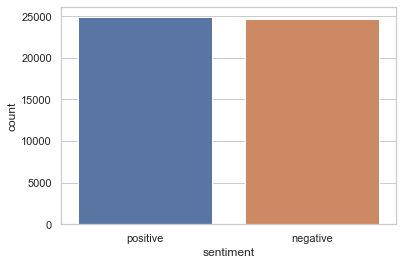

In [6]:
sns.set_theme(style = "whitegrid")
sns.countplot(x=imdb_data['sentiment'])

**Null values check**

In [7]:
bool_series = pd.isnull(imdb_data['sentiment'])
print("Null values in sentiment: ",len(imdb_data[bool_series]))

bool_series = pd.isnull(imdb_data['review'])
print("Null values in review: ",len(imdb_data[bool_series]))

Null values in sentiment:  0
Null values in review:  0


**Text normalization**

In [8]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')
stopword_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

**Removing html strips and noise text**

In [9]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

**Removing special characters**

In [10]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

**Text stemming**

In [11]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

**Lemmatization**

In [12]:
import gensim

#Create a lemmatizer
lemma = WordNetLemmatizer()

#Stem and lemmatize a term
def lemmatize(term):
    term = lemma.lemmatize(term, pos='v') # Lemmatize
    return term
    
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text): #Deaccents and splits terms
        token = re.sub("\W","",token) #Remove special characters, punctuation, spaces
        
        token = token.lower() #lowercase string
            
        if token.startswith("http"): #entity recognition of URLs.
            token = "URL_"
            
        if len(token) > 3:  
            result.append(lemmatize(token))
    result = ' '.join(result) 
    return result
imdb_data['review']=imdb_data['review'].apply(preprocess)

**Removing stopwords**

In [13]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{"shouldn't", 'him', 'my', "mustn't", 'we', 'yourselves', 'while', 'with', 'of', "that'll", "won't", 'it', 'haven', 'these', 'hers', 'through', 'further', 'd', 'why', 'shan', 'ain', 'shouldn', 'aren', 'your', 'herself', 'have', 'few', 'does', "weren't", 'into', 'as', 'there', "aren't", 'was', 'hasn', 'during', "shan't", 'ourselves', 'by', 'doing', 'such', 'at', 'do', 'yours', 'whom', 've', "couldn't", 'wasn', 'up', 'don', "wasn't", 'to', 'under', 'more', 'were', 'only', "it's", 'their', 'has', 'until', 'other', 'off', "isn't", 'won', 'm', 'our', 'when', 'been', 'theirs', 'between', 'they', 'had', 'his', 'again', 'how', 'o', 'hadn', 'll', 'is', "you've", 'having', 'me', 'against', 'for', 'an', 'than', 'any', 'if', 'i', "you'd", 'not', 't', 'isn', 'above', 'from', 'itself', 'needn', 'he', 'she', "doesn't", 'nor', 'in', "mightn't", 're', 'then', 'can', 'ours', "don't", 'y', "hadn't", 'because', 'mightn', 'on', 'themselves', 'ma', "you'll", 'who', 'where', 'here', 'being', 'that', 'out', '

**Normalized train reviews**

In [14]:
from sklearn.model_selection import train_test_split
y = imdb_data.iloc[:,1]
x = imdb_data.iloc[:,0]
# Split into training and test+
norm_train_reviews, norm_test_reviews, train_sentiments, test_sentiments = train_test_split(x, y, test_size=0.2, random_state=100)

In [15]:
norm_train_reviews[0]

'review mention watch episod youll hook right exactli happen meth first thing strike brutal unflinch scene violenc right word trust show faint heart timid show pull punch regard drug violenc hardcor classic wordit call nicknam give oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never awayi would main appeal show fact show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever strike nasti surreal couldnt readi watch develop tast accustom high level graphic violenc violenc injustic crook guard wholl sell nickel inmat wholl kill order away well manner middl class inmat turn prison bitch lack street skill prison experi watch becom comfort uncomfort viewingthat touch darker side'

**Normalized test reviews**

In [16]:
#Normalized test reviews
norm_test_reviews.head()

31904    rowan atkinson creation mrbean stand test time...
22259    page definit veri enthral captiv eyeopen veri ...
49495    person think film veri profession love choreog...
39584    pretti decent earli work kokaku kidotai withou...
21224    funni stop think fright film tend deep abid af...
Name: review, dtype: object

In [17]:
print(norm_train_reviews.shape,train_sentiments.shape)
print(norm_test_reviews.shape,test_sentiments.shape)

(39665,) (39665,)
(9917,) (9917,)


**Bags of words model **

It is used to convert text documents to numerical vectors or bag of words.

In [18]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (39665, 5509294)
BOW_cv_test: (9917, 5509294)


**Term Frequency-Inverse Document Frequency model (TFIDF)**

It is used to convert text documents to  matrix of  tfidf features.

In [19]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (39665, 5509294)
Tfidf_test: (9917, 5509294)


**Labeling the sentiment text**

In [21]:
lb=LabelBinarizer()
train_sentiments=lb.fit_transform(train_sentiments)
test_sentiments=lb.fit_transform(test_sentiments)
test_sentiments

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [22]:
#sentiment count train data
pd.DataFrame(train_sentiments).value_counts()

1    19871
0    19794
dtype: int64

In [23]:
pd.DataFrame(test_sentiments).value_counts()

1    5013
0    4904
dtype: int64

**Modelling the dataset**

Building logistic regression model for both bag of words and tfidf features

In [24]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


**Logistic regression model performane on test dataset**

In [25]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 1 0 ... 1 1 0]
[1 1 0 ... 1 1 0]


**Accuracy of the model**

In [26]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7152364626399113
lr_tfidf_score : 0.714328930119996


**Print the classification report**

In [50]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4918
    Negative       0.77      0.73      0.75      5082

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.70      0.83      0.76      4918
    Negative       0.80      0.66      0.72      5082

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



**Confusion matrix**

In [51]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3715 1367]
 [1110 3808]]
[[3374 1708]
 [ 857 4061]]


**Stochastic gradient descent or Linear support vector machines for bag of words and tfidf features**

In [52]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


**Model performance on test data**

In [53]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


**Accuracy of the model**

In [54]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.4969
svm_tfidf_score : 0.4918


**Print the classification report**

In [55]:
#Classification report for bag of words 
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.49      1.00      0.66      4918
    Negative       1.00      0.01      0.02      5082

    accuracy                           0.50     10000
   macro avg       0.75      0.51      0.34     10000
weighted avg       0.75      0.50      0.34     10000

              precision    recall  f1-score   support

    Positive       0.49      1.00      0.66      4918
    Negative       0.00      0.00      0.00      5082

    accuracy                           0.49     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.24      0.49      0.32     10000



**Plot the confusion matrix**

In [56]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[  51 5031]
 [   0 4918]]
[[   0 5082]
 [   0 4918]]


**Multinomial Naive Bayes for bag of words and tfidf features**

In [57]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


**Model performance on test data**

In [58]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[1 0 0 ... 0 1 0]
[1 0 0 ... 0 1 0]


**Accuracy of the model**

In [59]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.7531
mnb_tfidf_score : 0.7516


**Print the classification report**

In [60]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4918
    Negative       0.77      0.74      0.75      5082

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.73      0.79      0.76      4918
    Negative       0.78      0.72      0.75      5082

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



**Plot the confusion matrix**

In [61]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3748 1334]
 [1135 3783]]
[[3648 1434]
 [1050 3868]]


**Let us see positive and negative words by using WordCloud.**

**Word cloud for positive review words**

<function matplotlib.pyplot.show(close=None, block=None)>

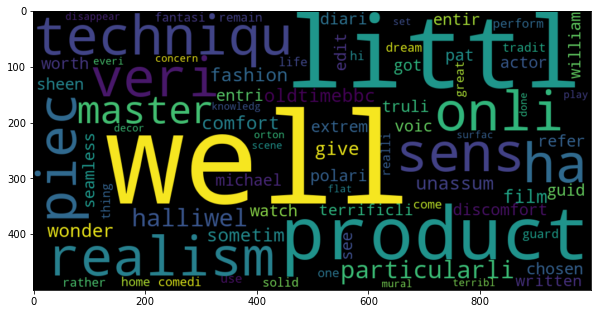

In [62]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

**Word cloud for negative review words**

<function matplotlib.pyplot.show(close=None, block=None)>

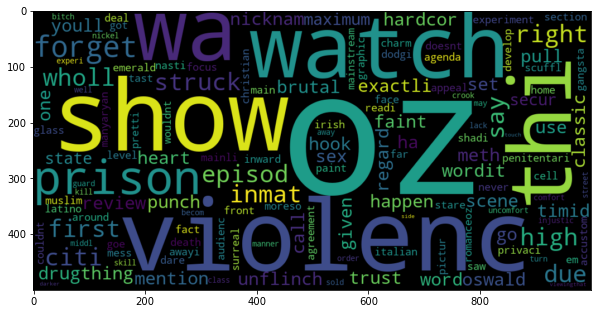

In [66]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[0]
# negative_text = negative_text[0]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

**Conclusion:**
* We can observed that both logistic regression and multinomial naive bayes model performing well compared to linear support vector  machines.
* Still we can improve the accuracy of the models by preprocessing data and by using lexicon models like Textblob.